# Analiza danych dot. emisji CO2 symulowanych przez model NASA-CASA .
**Autor: Bartłomiej Brzęk (141800)**

### Celem tej analizy jest ocena spójności, kompletności i wiarygodności danych dotyczących emisji CO2, z naciskiem na lokalizację pomiarów, identyfikację anomalii oraz porównanie skuteczności różnych modeli klasyfikacyjnych w kontekście dokładności lokalizacji i grupowania danych.

## Spis treści
[Wprowadzenie i inicjalizacja sesji Spark](#0)<br>
1. [Preprocessing danych](#1)<br>
    1.1. [Wczytanie danych](#1.1)<br>
    1.2. [Porównanie zbiorów](#1.2)<br>
    1.3. [Błędne lub puste dane](#1.3)<br>
    1.4. [Podmiana błędnych wartości na medianę](#1.4)<br>
    <br>
2. [Analiza eksploracyjna](#2)<br>
    2.1. [Sprawdzenie geolokalizacji](#2.1)<br>
    2.2. [Sprawdzenie fluktuacji wartości czujników](#2.2)<br>
    2.3. [Sprawdzenie korelacji pomiędzy czujnikami](#2.3)<br>
    <br>
3. [Klasyfikacja pomiarów czujników według lokalizacji](#3)<br>
    3.1. [Klasyfikacja lokalizacji pomiaru ze względu na miejsce (RandomForest)](#3.1)<br>
    3.2. [Klasyfikacja skupisk lokalizacji (DecisonTree)](#3.2)<br>
    <br>
4. [Posumowanie](#4)

## Wprowadzenie <a id="0"></a>

Zestawy danych zawierają oszacowania sygnałów emisji CO2 z biosfery, symulowane przez model NASA-CASA. Dane te bazują na predykcyjnych próbkach z gazów zebranych w listopadzie 2010 i maju 2011 roku. Zestaw ten jest częścią większego badania mającego na celu oszacowanie regionalnych i ogólnostanowych wymian węgla fosylnego i bioCO2 w Kalifornii, w którym wykorzystano symulowane obserwacje atmosferyczne oraz modelowane emisje z paliw kopalnych i fluktuacje CO2 w biosferze.

Poniżej znajduje się definicja kolumn przedstawionych w pliku:
- **site**: identyfikator miejsca pomiaru,
- **date**: data pomiaru w formacie RRRRMMDD,
- **longitude**: długość geograficzna miejsca pomiaru,
- **latitude**: szerokość geograficzna miejsca pomiaru,
- **reg01** - **reg17**: szacowane sygnały stężenia CO2 w atmosferze dla 17 czujników w każdym regionie (site) w jednostkach określanych jako częścih na milion (ppm).

Warto zaznaczyć, że analiza danych była prowadzona w braku dostępnego opisu lub kontekstu dotyczącego pomiarów. W związku z tym, analiza opierała się głównie na samych danych, bez wprowadzenia subiektywnego opisu. Brakujący opis utrudnia pełne zrozumienie kontekstu pomiarów, co wymagało opierania się na dostępnych danych i wiedzy eksperckiej w dziedzinie analizy danych.

### Inicjalizacja sesji Spark

In [1]:
import findspark 
findspark.init() 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('DataFrame_add').master('local[*]').getOrCreate()

## 1. Preprocessing danych <a id="1"></a>

W tej sekcji analizy przeprowadzana jest weryfikacja możliwości połączenia obu dostępnych zbiorów danych w jeden spójny zbiór. W ramach tego procesu wprowadzane są odpowiednie typy zmiennych dla poszczególnych kolumn. Dodatkowo, identyfikowane i rozwiązywane są problemy związane z pustymi lub błędnymi danymi.

In [2]:
from pyspark.sql.types import StructType, StructField, StringType, FloatType, DateType
import pyspark.sql.functions as F
from pyspark.sql.functions import col, to_date, isnan, when, lit, expr
from pyspark.sql.window import Window


import matplotlib.pyplot as plt

### Wczytanie danych <a id="1.1"></a>

In [3]:
data_nov2010 = spark.read.csv('./data/CASA_bioCO2_flask_region_201011.csv', header=True, inferSchema=False)
data_may2011 = spark.read.csv('./data/CASA_bioCO2_flask_region_201105.csv', header=True, inferSchema=False)

data_nov2010 = data_nov2010.filter(~col(data_nov2010.columns[0]).contains('text'))
data_may2011 = data_may2011.filter(~col(data_may2011.columns[0]).contains('text'))

for column in data_nov2010.columns:
    if column.startswith('reg'):
        data_nov2010 = data_nov2010.withColumn(column, col(column).cast(FloatType()))
        data_may2011 = data_may2011.withColumn(column, col(column).cast(FloatType()))
    elif column == 'date':
        data_nov2010 = data_nov2010.withColumn(column, to_date(col(column), 'yyyyMMdd'))
        data_may2011 = data_may2011.withColumn(column, to_date(col(column), 'yyyyMMdd'))
    elif column in ['longitude', 'latitude']:
        data_nov2010 = data_nov2010.withColumn(column, col(column).cast(FloatType()))
        data_may2011 = data_may2011.withColumn(column, col(column).cast(FloatType()))

### Porównanie zbiorów <a id="1.2"></a>

In [4]:
def print_column_types(df, df_name):
    """
    Funckja wyświetlająca typy kolumn DataFrame pySpark
    
    Parametry:
    - df : pySpark DataFrame
    - df_name : nazwa ramki danych
    """
    print(f"\nTypy kolumn w dataframe {df_name}:")
    for field in df.schema.fields:
        print(f"{field.name}: {field.dataType}")

print_column_types(data_nov2010, 'data_nov2010')
print_column_types(data_may2011, 'data_may2011')


Typy kolumn w dataframe data_nov2010:
site: StringType()
date: DateType()
longitude: FloatType()
latitude: FloatType()
reg01: FloatType()
reg02: FloatType()
reg03: FloatType()
reg04: FloatType()
reg05: FloatType()
reg06: FloatType()
reg07: FloatType()
reg08: FloatType()
reg09: FloatType()
reg10: FloatType()
reg11: FloatType()
reg12: FloatType()
reg13: FloatType()
reg14: FloatType()
reg15: FloatType()
reg16: FloatType()
reg17: FloatType()

Typy kolumn w dataframe data_may2011:
site: StringType()
date: DateType()
longitude: FloatType()
latitude: FloatType()
reg01: FloatType()
reg02: FloatType()
reg03: FloatType()
reg04: FloatType()
reg05: FloatType()
reg06: FloatType()
reg07: FloatType()
reg08: FloatType()
reg09: FloatType()
reg10: FloatType()
reg11: FloatType()
reg12: FloatType()
reg13: FloatType()
reg14: FloatType()
reg15: FloatType()
reg16: FloatType()
reg17: FloatType()


Oba zbiory danych mają takie same kolumny.


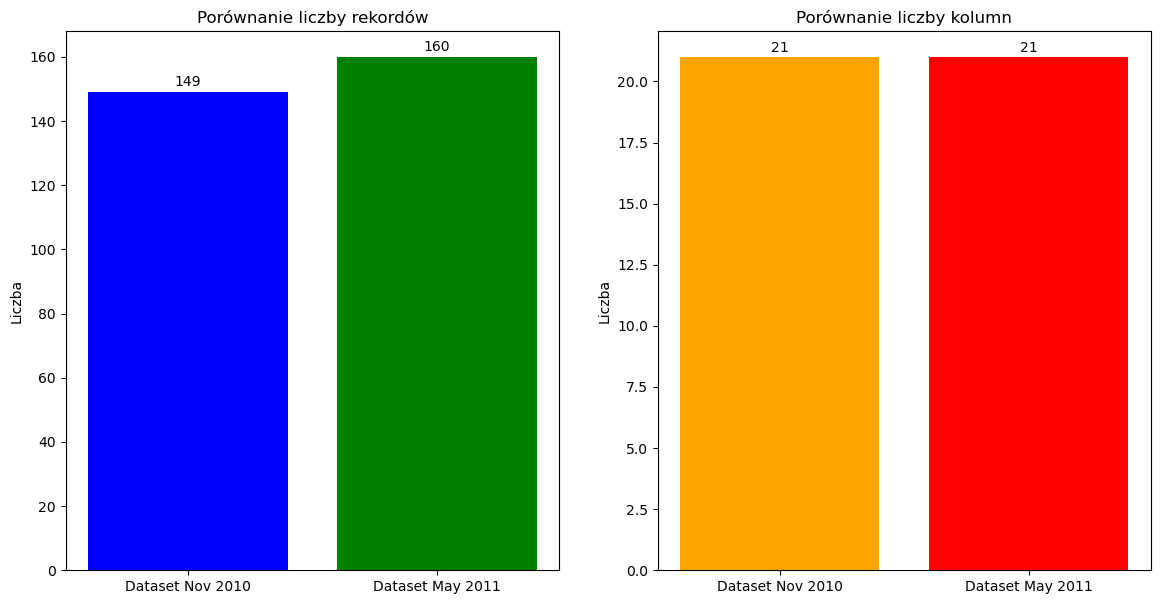

In [5]:
num_records_df1 = data_nov2010.count()
num_columns_df1 = len(data_nov2010.columns)

num_records_df2 = data_may2011.count()
num_columns_df2 = len(data_may2011.columns)

datasets = ['Dataset Nov 2010', 'Dataset May 2011']
records = [num_records_df1, num_records_df2]
columns = [num_columns_df1, num_columns_df2]

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

bars1 = ax[0].bar(datasets, records, color=['blue', 'green'])
ax[0].set_title('Porównanie liczby rekordów')
ax[0].set_ylabel('Liczba')
for bar in bars1:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

bars2 = ax[1].bar(datasets, columns, color=['orange', 'red'])
ax[1].set_title('Porównanie liczby kolumn')
ax[1].set_ylabel('Liczba')
for bar in bars2:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval + 0.1, yval, ha='center', va='bottom')

columns_df1 = set(data_nov2010.columns)
columns_df2 = set(data_may2011.columns)

if columns_df1 == columns_df2:
    print("Oba zbiory danych mają takie same kolumny.")
else:
    print("Zbiory danych mają różne kolumny.")
    
    diff_df1 = columns_df1 - columns_df2
    diff_df2 = columns_df2 - columns_df1

    if diff_df1:
        print(f"Kolumny, które są w CASA_bioCO2_flask_region_201011 nie są w CASA_bioCO2_flask_region_201105: {diff_df1}")
    if diff_df2:
        print(f"Kolumny, które są w CASA_bioCO2_flask_region_201105 nie są w CASA_bioCO2_flask_region_201011: {diff_df2}")

plt.show()

**Porównanie zbiorów**

Na podstawie przeprowadzonej analizy stwierdzono, że liczba rekordów w drugim zbiorze danych (CASA_bioCO2_flask_region_201105) jest większa niż w pierwszym zbiorze (CASA_bioCO2_flask_region_201011). Mimo różnicy w ilości rekordów, oba zbiory danych mają taką samą liczbę kolumn o takich samych nazwach. Ta konsystencja w strukturze danych umożliwia łatwe złączenie tych dwóch zbiorów w jeden większy zbiór danych.

**Złączenie CASA_bioCO2_flask_region_201011 i CASA_bioCO2_flask_region_201105 do jednej ramki danych**

In [6]:
data = data_nov2010.union(data_may2011)

### Błędne lub puste dane <a id="1.3"></a>
- **błędne dane** ujemne lub dodatnie, nierealistycznie wysokie wartości,
- **puste dane** oznaczone wartości null lub NaN.

W kontekście używanych danych, wartości ujemne dla niektórych kolumn (np. reg01 - reg17) niekoniecznie oznaczają błędy. Te kolumny prawdopodobnie reprezentują poziomy lub pomiarów, które mogą się zmieniać w czasie i przyjmować zarówno wartości dodatnie, jak i ujemne. Wartości ujemne mogą wskazywać na spadek lub zmniejszenie danego pomiaru, podczas gdy wartości dodatnie sugerują wzrost.

Dodatkowo poczynione zostało założenie, że wartość przewidywanego wzrostu emisji CO2 nie może przekraczać 6 ppm.

In [7]:
def check_faulty_data(df, threshold):
    """
    Funkcja do sprawdzania błędnych danych w DataFrame.

    Parametry:
    df (DataFrame) - DataFrame PySpark, w którym będą szukane błędne dane.
    threshold (float/int) - Próg wartości, powyżej którego dane będą uznane za nierealistycznie wysokie.

    Funkcja przeszukuje każdą kolumnę w podanym DataFrame pod kątem trzech rodzajów błędnych danych:
    1. Wartości ujemne: Sprawdza, czy istnieją wartości ujemne w kolumnie.
    2. Wartości przekraczające próg: Sprawdza, czy istnieją wartości wyższe niż podany próg w kolumnie.
    3. Puste lub NaN wartości: Sprawdza, czy istnieją puste (null) lub NaN wartości w kolumnie.

    Dla każdego rodzaju błędu, jeśli zostanie znaleziony, funkcja wypisuje informację o liczbie takich wartości w danej kolumnie.
    """
    columns = df.columns
    for column in columns:
        if not column.startswith('site') and not column.startswith('date') and not column.startswith('longitude') and not column.startswith('latitude'):
            negative_values_count = df.filter(df[column] < 0).count()
            if negative_values_count > 0:
                print(f'Kolumna {column} w zbiorze ma {negative_values_count} ujemnych wartości.')

            high_values_count = df.filter(df[column] > threshold).count()
            if high_values_count > 0:
                print(f'Kolumna {column} w zbiorze ma {high_values_count} wartości powyżej progu 6 ppm.')
        
        if not column.startswith('date'):
            null_count = df.filter(df[column].isNull() | isnan(df[column])).count()
            if null_count > 0:
                print(f'Kolumna {column} w zbiorze ma {null_count} null lub NaN wartości.')
threshold = 6
check_faulty_data(data, threshold)

Kolumna reg01 w zbiorze ma 75 ujemnych wartości.
Kolumna reg02 w zbiorze ma 79 ujemnych wartości.
Kolumna reg02 w zbiorze ma 3 wartości powyżej progu 6 ppm.
Kolumna reg03 w zbiorze ma 101 ujemnych wartości.
Kolumna reg03 w zbiorze ma 1 wartości powyżej progu 6 ppm.
Kolumna reg04 w zbiorze ma 65 ujemnych wartości.
Kolumna reg05 w zbiorze ma 73 ujemnych wartości.
Kolumna reg06 w zbiorze ma 36 ujemnych wartości.
Kolumna reg07 w zbiorze ma 117 ujemnych wartości.
Kolumna reg07 w zbiorze ma 2 wartości powyżej progu 6 ppm.
Kolumna reg08 w zbiorze ma 72 ujemnych wartości.
Kolumna reg09 w zbiorze ma 57 ujemnych wartości.
Kolumna reg10 w zbiorze ma 41 ujemnych wartości.
Kolumna reg11 w zbiorze ma 53 ujemnych wartości.
Kolumna reg12 w zbiorze ma 62 ujemnych wartości.
Kolumna reg12 w zbiorze ma 2 wartości powyżej progu 6 ppm.
Kolumna reg13 w zbiorze ma 20 ujemnych wartości.
Kolumna reg14 w zbiorze ma 47 ujemnych wartości.
Kolumna reg15 w zbiorze ma 49 ujemnych wartości.
Kolumna reg16 w zbiorze ma 

**Wniosek**

Ilość ujemnych danych w kolumnach reg01 - reg17 sugeruje, że te wartości są poprawne zgodnie z przewidywaniami. Niemniej jednak, brak pełnych informacji o zbiorze danych uniemożliwia dokładną weryfikację i zrozumienie kontekstu tych danych. Dlatego też, choć są one zgodne z oczekiwaniami, to pełna interpretacja wymagałaby dostępu do bardziej szczegółowych informacji na temat zbioru danych.

Dodatkowo, po ustawieniu progu emisji CO2 na poziomie 6, zauważono, że w pięciu regionach wartości estymowane przekroczyły ten próg. To oznacza, że w tych pięciu regionach istnieje tendencja do wyższego poziomu danych w porównaniu z innymi obszarami. Można to uznać za błąd, ponieważ przekroczenie ustalonego progu w pięciu regionach może wskazywać na nietypowe lub niepoprawne dane.

Warto zaznaczyć, że w przypadku tych danych nie występują puste ani wartości NaN, co może sugerować, że są one w miarę kompleksowe i spójne pod względem brakujących danych.

### Podmiana błędnych wartości na medianę <a id="1.4"></a>

Podmiana wartości, które przekraczają określony próg na medianę jest wykonywana ze względu na jej stabilność wobec wartości odstających (outliers). Mediana jest statystyczną miarą centralnej tendencji, która nie jest wrażliwa na wartości odstające. W przypadku danych związanymi z analizą chemiczną (CO2), mogą występować wartości skrajne, które są wynikiem błędów przewidywań pomiarowych lub innych czynników, ale niekoniecznie są błędne. Zastępując je medianą, zachowywana jest istniejąca wariancja danych, co może być bardziej odpowiednie niż usuwanie lub zastępowanie ich średnią arytmetyczną.

In [8]:
def replace_outliers_with_median(df, threshold=6):
    """
    Funkcja przyjmuje DataFrame `df` oraz opcjonalny próg (domyślnie 6 ppm). Oblicza medianę dla kolumn numerycznych
    (wyłączając niektóre kolumny) i zastępuje wartości przekraczające próg obliczoną medianą. Pomaga to zmniejszyć wpływ
    wartości odstających na analizę danych, jednocześnie zachowując rozkład danych. Wynikowy DataFrame
    `data_without_outliers` zawiera dane, w których wartości odstające zostały zastąpione medianą danej kolumny.
    
    Parametry:
    df - DataFrame z danymi
    threshold - Próg dla wartości odstających (domyślnie 6 ppm)
    
    Zwrot:
    return - DataFrame z zastąpionymi wartościami odstającymi medianą
    """
    columns = df.columns
    for column in columns:
        if column.startswith('reg'):
            median_value = df.approxQuantile(column, [0.5], 0.25)[0]
            df = df.withColumn(column, when(col(column) > threshold, median_value).otherwise(col(column)))
    return df

data = replace_outliers_with_median(data)

## 2. Analiza eksploracyjna <a id="2"></a>

Analiza eksploracyjna w badaniu danych obejmuje trzy kluczowe elementy: geolokalizację, fluktuacje wartości czujników oraz korelacje między czujnikami. Prezentacja geolokalizacji umożliwia zrozumienie rozmieszczenia punktów pomiarowych, co jest ważne dla kontekstualizacji danych. Analiza fluktuacji wartości czujników koncentruje się na identyfikacji wzorców i stabilności danych, co jest istotne dla oceny ich jakości i wiarygodności. Badanie korelacji między czujnikami pozwala na wykrywanie zależności pomiędzy zmiennymi, co jest kluczowe dla zrozumienia kompleksowości badanych zjawisk. Połączenie tych elementów tworzy pełny obraz danych, niezbędny do efektywnej i rzetelnej analizy.

In [9]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.colors as mcolors
import numpy as np

In [10]:
pandas_df = data.toPandas()

### Sprawdzenie geolokalizacji <a id="2.1"></a>

Użycie wizualizacji, szczególnie poprzez zastosowanie różnorodnych kolorów dla każdej lokalizacji, znacząco ułatwia identyfikację i zrozumienie rozmieszczenia punktów pomiarowych. Każda stacja pomiarowa, reprezentowana przez unikalny identyfikator 'site', jest łatwo rozpoznawalna dzięki kolorystycznemu oznaczeniu. Dodanie legendy do wizualizacji dodatkowo ułatwia szybki przegląd i orientację w rozmieszczeniu stacji, co jest istotne dla precyzyjnej interpretacji i analizy zebranych danych. Wizualizacja ta nie tylko ułatwia zrozumienie fizycznej lokalizacji stacji pomiarowych, ale również pozwala na lepsze zrozumienie kontekstu geograficznego zebranych danych.

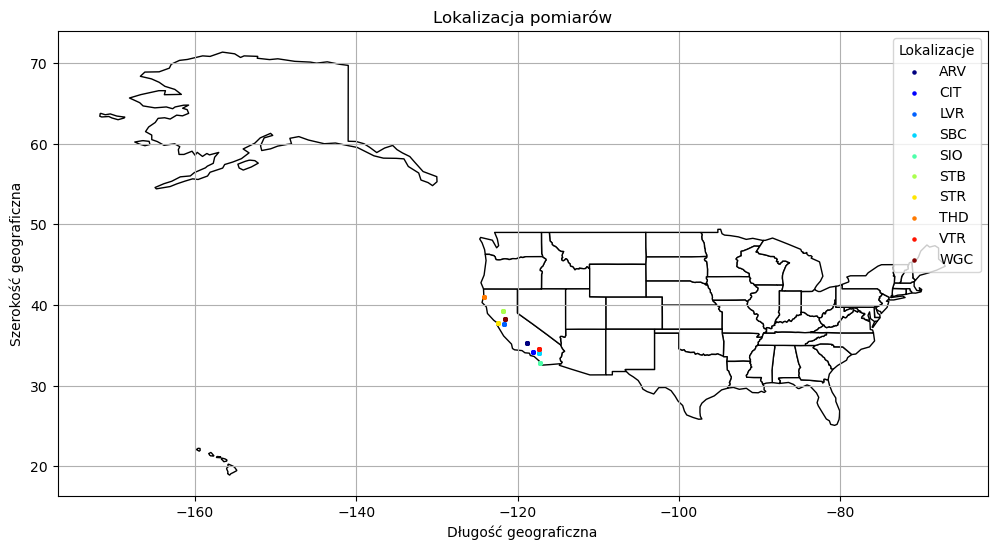

In [11]:
gdf = gpd.GeoDataFrame(pandas_df, geometry=gpd.points_from_xy(pandas_df.longitude, pandas_df.latitude))

unique_sites = gdf['site'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_sites)))
site_colors = {site: color for site, color in zip(unique_sites, colors)}
gdf['color'] = gdf['site'].map(site_colors)

world = gpd.read_file('./data/map/ne_110m_admin_1_states_provinces.shp')

plt.figure(figsize=(12, 8))
world.plot(ax=plt.gca(), color='white', edgecolor='black')

for site, color in site_colors.items():
    gdf_site = gdf[gdf['site'] == site]
    gdf_site.plot(ax=plt.gca(), marker='o', color=color, markersize=5, label=site)

plt.legend(title='Lokalizacje')

plt.title("Lokalizacja pomiarów")
plt.xlabel('Długość geograficzna')
plt.ylabel('Szerokość geograficzna')
plt.grid(True)
plt.show()

Ta wizualizacja pokazuje rozmieszczenie miejsc pomiarowych w Kalifornii. Użycie różnych kolorów dla poszczególnych lokalizacji, reprezentowanych przez unikalne identyfikatory 'site', pozwala na łatwe rozróżnienie i lokalizację każdego punktu pomiarowego. Dodatkowo, legenda dostarcza szybkiego przeglądu wszystkich lokalizacji, co ułatwia zrozumienie rozmieszczenia stacji pomiarowych.

### Sprawdzenie fluktuacji wartości czujników <a id="2.2"></a>

Sprawdzanie fluktuacji wartości czujników jest kluczowym etapem w procesie analizy danych, szczególnie tych symulujących emisje CO2 przez model NASA-CASA. Ta część analizy pozwala na identyfikację ewentualnych anomalii oraz ocenę niezawodności poszczególnych czujników. Zwracając uwagę na wahania w danych, możemy wykryć potencjalne błędy lub nieprawidłowości, które mogą wpływać na dokładność i wiarygodność całego zbioru danych. Takie podejście jest niezbędne, aby zapewnić, że wyniki analizy są oparte na rzetelnych i spójnych danych, co jest kluczowe dla dalszych wniosków i decyzji dotyczących modelowania i interpretacji danych.

In [12]:
from pyspark.sql.functions import mean, year

In [13]:
sensor_columns = [column for column in data.columns if column.startswith('reg')]

averages = [mean(col(c)).alias(c) for c in sensor_columns]

data_2010 = data.filter(year('date') == 2010)
grouped_data_2010 = data_2010.groupBy('date').agg(*averages)

data_2011 = data.filter(year('date') == 2011)
grouped_data_2011 = data_2011.groupBy('date').agg(*averages)

pandas_df_2010 = grouped_data_2010.toPandas()
pandas_df_2011 = grouped_data_2011.toPandas()

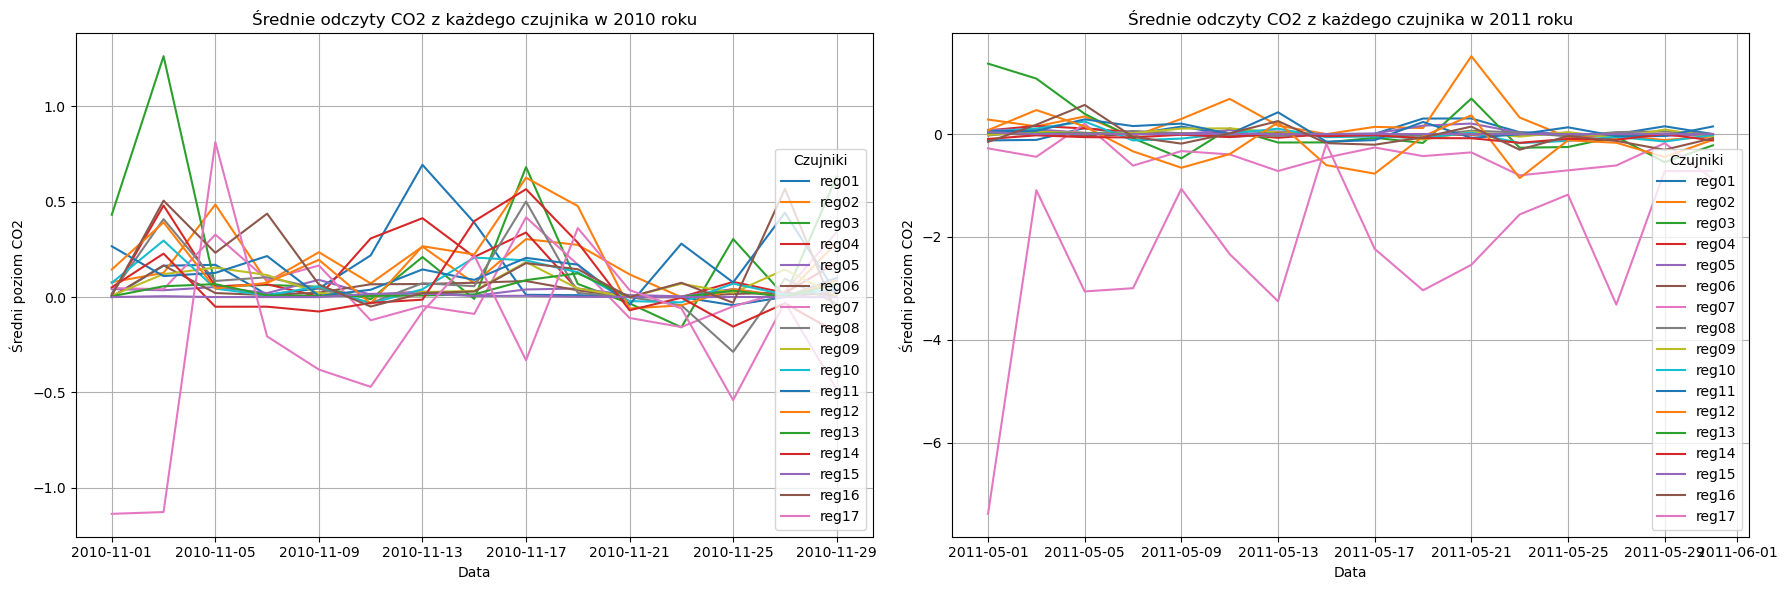

In [14]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
for sensor in sensor_columns:
    sns.lineplot(x='date', y=sensor, data=pandas_df_2010, label=sensor)
plt.title('Średnie odczyty CO2 z każdego czujnika w 2010 roku')
plt.xlabel('Data')
plt.ylabel('Średni poziom CO2')
plt.legend(title='Czujniki', loc=4)
plt.grid(True)

plt.subplot(1, 2, 2)
for sensor in sensor_columns:
    sns.lineplot(x='date', y=sensor, data=pandas_df_2011, label=sensor)
plt.title('Średnie odczyty CO2 z każdego czujnika w 2011 roku')
plt.xlabel('Data')
plt.ylabel('Średni poziom CO2')
plt.legend(title='Czujniki', loc=4)
plt.grid(True)

plt.tight_layout()
plt.show()

Jak można zauważyć, najbardziej wyróżniającym się czujnikiem jest czujnik reg17, którego symulacja wykazuje znaczne wahania w dużych zakresach w roku 2010 i 2011. Można przypuszczać, że te wahania mogą wynikać z niepoprawnego działania tego czujnika, dlatego w dalszych analizach można go zignorować. Dlatego zostanie on usunięty z zbioru.

In [15]:
data = data.drop('reg17')
sensor_columns.remove('reg17')

### Sprawdzenie korelacji pomiędzy czujnikami <a id="2.3"></a>

Analiza macierzy korelacji jest kluczowym elementem w badaniu zestawów danych, takich jak te zawierające oszacowania sygnałów emisji CO2 z biosfery, symulowane przez model NASA-CASA.

In [16]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

In [17]:
vector_assembler = VectorAssembler(inputCols=sensor_columns, outputCol="features")
data = vector_assembler.transform(data)

correlation_matrix = Correlation.corr(data, "features").head()

corr_matrix = correlation_matrix[0]

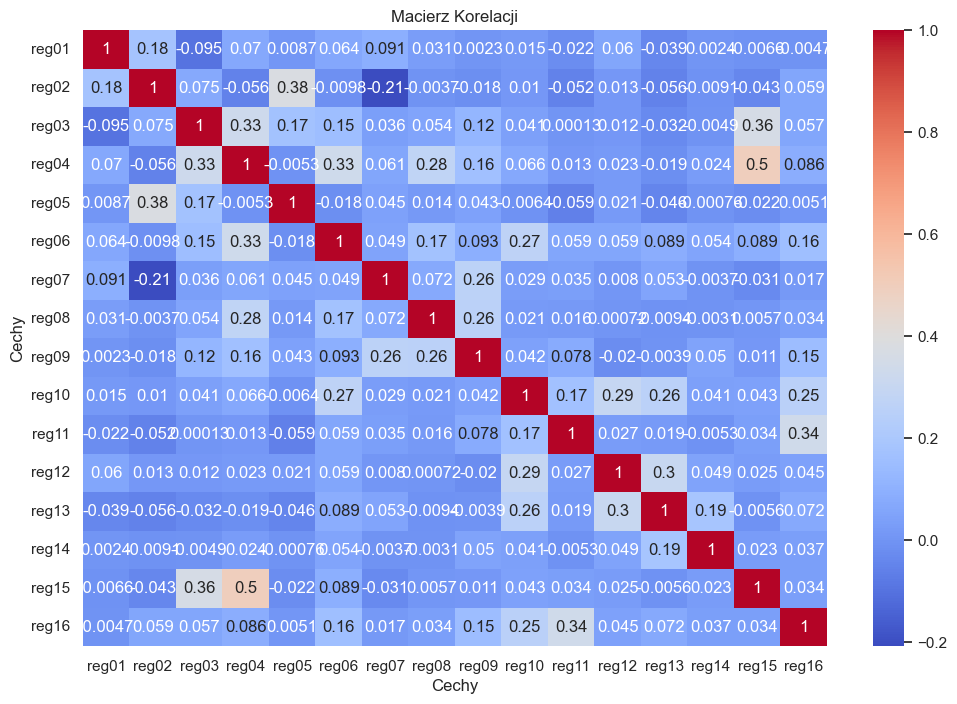

In [18]:
corr_matrix_array = corr_matrix.toArray()
n = len(sensor_columns)

plt.figure(figsize=(12, 8))

sns.set(font_scale=1)
sns.heatmap(corr_matrix_array, annot=True, cmap='coolwarm', xticklabels=sensor_columns, yticklabels=sensor_columns)

plt.title('Macierz Korelacji')
plt.xlabel('Cechy')
plt.ylabel('Cechy')
plt.show()

data = data.drop('features')

Analiza macierzy korelacji wykazała, że istnieje znacząca korelacja o wartości **0.5** między cechami **'reg04'** i **'reg15'**. Sugeruje to, że te dwie cechy są w pewnym stopniu powiązane ze sobą. Jednakże, dla pozostałych cech nie obserwujemy istotnych korelacji, co oznacza, że nie wyróżniają się one pod względem powiązań. To odkrycie może być istotne w kontekście dalszej analizy danych i podejmowania decyzji dotyczących modelowania.

## 3. Klasyfikacja pomiarów czujników według lokalizacji <a id="3"></a>

Klasyfikacja pomiarów czujników według lokalizacji skupia się na porównaniu dwóch metod klasyfikacyjnych. Random Forest dla dokładnej lokalizacji grupy czujników oraz Decision Tree dla skupisk lokalizacji grup czujników. Ta analiza pozwoli na zrozumienie, jak różne podejścia klasyfikacyjne mogą wpływać na dokładność i skuteczność identyfikacji lokalizacji czujników.

### Klasyfikacja lokalizacji pomiaru ze względu na miejsce <a id="3.1"></a>

In [19]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

assembler = VectorAssembler(inputCols=sensor_columns, outputCol="features")

labelIndexer = StringIndexer(inputCol="site", outputCol="label")

rf = RandomForestClassifier(labelCol="label", featuresCol="features")

pipeline = Pipeline(stages=[labelIndexer, assembler, rf])

(trainingData, testData) = data.randomSplit([0.7, 0.3])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

In [20]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Accuracy = %g" % accuracy)

f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("F1 Score = %g" % f1)

precision = evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel"})
print("Precision = %g" % precision)

recall = evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel"})
print("Recall = %g" % recall)

Accuracy = 0.56
F1 Score = 0.535439
Precision = 0.8
Recall = 0.666667


Model **RandomForestClassifier** został przetestowany na zbiorze danych zawierającym odczyty z 17 czujników (reg01-17) dla różnych regionów (site). Otrzymane wyniki oceny modelu prezentują się następująco:

- **Dokładność (Accuracy)** - 56%. Ta wartość wskazuje, że model poprawnie sklasyfikował około 56% przypadków ze zbioru testowego. Jest to miara ogólnej skuteczności modelu w przewidywaniu zarówno pozytywnych, jak i negatywnych klas. Chociaż wynik ten jest lepszy niż losowy wybór, sugeruje on średnią wydajność modelu w kontekście zadania klasyfikacji.

- **F1 Score** - 53.54%. Wskaźnik F1 jest średnią harmonijną precyzji i czułości (recall) i jest używany do oceny modelu, gdy chcemy zrównoważyć znaczenie obu tych metryk. Wynik F1 na poziomie 53.54% sugeruje, że model ma umiarkowaną zdolność do klasyfikacji prawidłowych przypadków, ale równocześnie ma pewne ograniczenia w jednoczesnym minimalizowaniu fałszywych pozytywów i fałszywych negatywów.

- **Precyzja (Precision)**: 80%. Precyzja odnosi się do procentu prawidłowych pozytywnych przewidywań w stosunku do wszystkich pozytywnych przewidywań dokonanych przez model. W tym przypadku wysoka wartość precyzji (80%) wskazuje, że znaczna część przewidywań pozytywnych dokonanych przez model jest prawidłowa.

- **Czułość (Recall)**: 66.66%. Czułość mierzy zdolność modelu do prawidłowego zidentyfikowania rzeczywistych pozytywów. Wartość 66.66% wskazuje, że model jest stosunkowo dobry w wykrywaniu prawdziwych pozytywnych przypadków, ale kosztem wyższej liczby fałszywych pozytywów, co jest odzwierciedlone w niskiej precyzji.

Podsumowując, model wykazuje umiarkowaną skuteczność w klasyfikacji, z dobrą zdolnością do identyfikacji prawdziwych pozytywów, ale ma znaczne problemy z generowaniem dużej liczby fałszywych pozytywów, co skutkuje niską precyzją. Wyniki te sugerują, że model może wymagać dalszej optymalizacji, być może poprzez dostosowanie parametrów.

### Klasyfikacja skupisk lokalizacji <a id="3.2"></a>

Opracowując wizualizację przedstawiającą mapę Stanów Zjednoczonych, zaobserwowano interesującą dychotomię. Zwracała uwagę obecność trzech wyraźnych skupisk kropek, symbolizujących konkretne lokalizacje. Ta obserwacja stała się kluczowym bodźcem do opracowania nowego klasyfikatora. Cel jest jasny: poprawa zdolności klasyfikacyjnych w kontekście analizy odczytów z symulacji. Wizualna analiza danych dostarczyła istotnych wskazówek, sugerujących, że taki podział może być efektywnie wykorzystany do precyzyjniejszego przyporządkowania danych do odpowiednich kategorii, co może znacząco poprawić wyniki klasyfikacji.

In [21]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

data = data.withColumn('cluster', 
                        when(col('site') == "STR", 0).when(col('site') == "STB", 0)
                        .when(col('site') == "WGC", 0).when(col('site') == "LVR", 0)
                        .when(col('site') == "VTR", 1).when(col('site') == "SBC", 1)
                        .when(col('site') == "SIO", 1).when(col('site') == "CIT", 1)
                        .when(col('site') == "ARV", 1).when(col('site') == "THD", 2))

assembler = VectorAssembler(inputCols=sensor_columns, outputCol="features")

dt = DecisionTreeClassifier(labelCol="cluster", featuresCol="features")

pipeline = Pipeline(stages=[assembler, dt])

(trainingData, testData) = data.randomSplit([0.7, 0.3])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

In [22]:
evaluator = MulticlassClassificationEvaluator(labelCol="cluster", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Accuracy = %g" % accuracy)

f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("F1 Score = %g" % f1)

precision = evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel"})
print("Precision = %g" % precision)

recall = evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel"})
print("Recall = %g" % recall)

Accuracy = 0.802083
F1 Score = 0.816671
Precision = 0.857143
Recall = 0.685714


**Analiza i porównanie wyników klasyfikacji przy użyciu DecisionTreeClassifier (Drzewa Decyzyjnego) dla 3 skupisk lokalizacji oraz RandomForestClassifier (Lasu Losowego) dla 10 dokładnych lokalizacji pokazuje znaczące różnice w skuteczności obu modeli.**

### Nowe Wyniki: DecisionTreeClassifier na 3 Skupiskach Lokalizacji
- **Dokładność (Accuracy)**: 80.20%
- **F1 Score**: 81.66%
- **Precyzja (Precision)**: 85.71%
- **Recall**: 68.57%

### Stare Wyniki: RandomForestClassifier na 10 Lokalizacjach
- **Dokładność (Accuracy)**: 56%
- **F1 Score**: 53.54%
- **Precyzja (Precision)**: 80%
- **Recall**: 66.66%


### Interpretacja Wyników
#### Poprawa Dokładności i Ogólnej Skuteczności
Model DecisionTreeClassifier na 3 skupiskach lokalizacji wykazuje znacząco wyższą dokładność (80.20%) w porównaniu z modelem RandomForestClassifier na 10 lokalizacjach (56%). To wskazuje na lepsze ogólne dopasowanie modelu Drzewa Decyzyjnego do tych danych.

#### Znaczący Wzrost F1 Score
F1 Score dla modelu DecisionTreeClassifier (81.66%) jest znacznie wyższy niż dla RandomForestClassifier (53.54%), co świadczy o lepszym balansie między precyzją a recall w przypadku Drzewa Decyzyjnego.

#### Wyższa Precyzja i Recall
DecisionTreeClassifier wykazuje również wyższe wartości precyzji i recall, co oznacza, że model lepiej identyfikuje prawidłowe klasyfikacje i rzadziej pomija istotne przypadki.

### Wnioski
Klasyfikacja na mniej licznych, ale bardziej ogólnych skupiskach lokalizacji może być bardziej efektywna niż na bardziej szczegółowych, ale liczniejszych lokalizacjach. Skupienie na kluczowych charakterystykach danych, zamiast na szczegółowych różnicach, pozwoliło modelowi Drzewa Decyzyjnego lepiej uchwycić ogólne wzorce.

### Wybór modelu
Wyniki sugerują, że dla tego konkretnego przypadku użycia model DecisionTreeClassifier może być bardziej odpowiedni niż RandomForestClassifier, zwłaszcza przy klasyfikacji opartej na skupiskach.

## Podsumowanie <a id="4"></a>

Podsumowując przeprowadzoną analizę danych, należy zwrócić uwagę na kilka kluczowych punktów. Brak dodatkowego kontekstu dla danych wymusił oparcie analizy wyłącznie na dostępnych informacjach, co ograniczyło głębokość zrozumienia kontekstu pomiarów. Mimo to, udało się zauważyć, że drugi zbiór danych zawierał więcej rekordów niż pierwszy, lecz oba charakteryzowały się taką samą strukturą, co ułatwiło ich połączenie.

Analiza wartości w kolumnach reg01 - reg17 sugeruje ich poprawność, choć brak pełnych informacji o zbiorze danych utrudnia dokładną weryfikację. Ponadto, przekroczenie ustalonego progu emisji CO2 w pięciu regionach wskazuje na potencjalne nieprawidłowości w danych. Warto również zaznaczyć, że dane były wolne od pustych wartości, co sugeruje ich kompleksowość i spójność.

Wizualizacja miejsc pomiarowych pozwoliła na łatwą identyfikację i lokalizację punktów pomiarowych w Kalifornii. Natomiast fluktuacje czujnika reg17, sugerujące jego potencjalne niepoprawne działanie, doprowadziły do jego wykluczenia z dalszej analizy. Analiza korelacji wykazała istotne powiązanie między cechami 'reg04' i 'reg15', ale brak znaczących korelacji dla innych cech.

Kluczowym elementem analizy było porównanie skuteczności klasyfikacji przy użyciu DecisionTreeClassifier dla skupisk lokalizacji oraz RandomForestClassifier dla dokładnych lokalizacji. Wyniki wykazały, że klasyfikacja na mniej licznych, ale bardziej ogólnych skupiskach lokalizacji była bardziej efektywna niż klasyfikacja na bardziej szczegółowych lokalizacjach. DecisionTreeClassifier osiągnął wyższą dokładność, F1 Score, precyzję i recall, co sugeruje lepsze dopasowanie tego modelu do analizowanych danych. Wyniki te podkreślają znaczenie odpowiedniego doboru modelu w zależności od charakterystyki danych i celu badania.